## All drugs training and RFE

The main task - repeat the procedure of evaluation of feature importance performed for drug-by-drug 
<br> but apply to all drug training

In [49]:
import pandas as pd
import numpy as np
import os

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score

from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_absolute_error
from sklearn.externals import joblib

import matplotlib.pyplot as plt


import warnings
warnings.filterwarnings("ignore")

_FOLDER = "results/"
_FOLDER_2= "data/"

In [2]:

def sigmoid_2_param(x, p, s):
    """ Sigmoid function from Dennis Wang's paper:
    x - dosage [0, 1],
    p - position,        default=0.4
    s - shape parameter, default=-1
    """
    return ( 1.0 / (1.0 + np.exp((x-p)/s)) )


def fsigmoid(x, p, k):
    """ Comparing with sigmoid_2_param:
    x = x  - dosage [0, 1]
    p - position [0,1],           default=0.4
    k = -1/s (s -shape parameter) default=0.4
    """
    return ( 1.0 / (1.0 + np.exp(-k*(x-p))) )

def sigmoid_3_param(x, x0, k, d):
    """ Comparing with sigmoid_2_param:
    x0 -  p - position, correlation with IC50 or EC50
    k = -1/s (s -shape parameter)
    d - determines the vertical position of the sigmoid - shift on y axis - better fitting then sigmoid_2_param
        """
    return ( 1/ (1 + np.exp(-k*(x-x0))) + d )


def sigmoid_4_param(x, x0, L, k, d):
    """ Comparing with sigmoid_2_param:
    x0 -  p - position, correlation with IC50 or EC50
    L = 1 in sigmoid_2_param, protect from devision by zero if x is too small 
    k = -1/s (s -shape parameter)
    d - determines the vertical position of the sigmoid - shift on y axis - better fitting then sigmoid_2_param

    """
    return ( 1/ (L + np.exp(-k*(x-x0))) + d)



def ll4_4_param(x, e, c, b, d):
    """ https://gist.github.com/yannabraham/5f210fed773785d8b638
    This function is basically a copy of the LL.4 function from the R drc package:
     - b: hill slope
     - d: min response - determines the vertical position of the graph
     - c: max response
     - e: EC50
     c-d - difference between max and min responses
     np.exp( b* (np.log(x)-np.log(e)) -  np.exp((x-p)/s in sigmoid_2_param
     b- hill slope = 1/s - shape parameter
     np.log(x)-np.log(e) == x-p in sigmoid_2_param
     """
    return ( (c-d)/(1 + np.exp( b*(np.log(x)-np.log(e) ))) + d)


def ll4R_4_param(x, c, a, b, d):
    """ LL.4 function from R
    https://www.rdocumentation.org/packages/drc/versions/2.5-12/topics/LL.4
   
    a-d - difference between max and min responses
    np.exp( b* np.log(x) - e) -  np.exp((x-p)/s in sigmoid_2_param
    b - hill slope = 1/s - shape parameter
    np.log(x)- e/b == x-p in sigmoid_2_param

    """
    return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)


def logistic_4_param(x, A, B, C, d):
    """ https://people.duke.edu/~ccc14/pcfb/analysis.html
    4PL logistic equation
    sigmoid_2_param: 1.0 / (1.0 + np.exp((x-p)/s)
    (A - d) = 1 in sigmoid_2_param:
    (x/C)**B  - corresponds to np.exp((x-p)/s
    d - determines the vertical position of the graph
    """
    return ( (A-d)/(1.0+((x/C)**B)) + d )


def logLogist_3_param(x, EC50, HS, E_inf):
    """Python analog for PharmacoGx/R/LogLogisticRegression.R
    https://github.com/bhklab/PharmacoGx/blob/master/R/LogLogisticRegression.R
    E = E_inf + (1 - E_inf)/(1 + (x/EC50)^HS)
    sigmoid_2_param: 1.0 / (1.0 + np.exp((x-p)/s)
    
    (A - d) = 1 in sigmoid_2_param:
    (np.log10(x)/EC50)**HS  - (in logistic4 (x/C)**B) corresponds to np.exp((x-p)/s 
    
    E_inf - determines the vertical position of the graph /coefficient d, min response in other functions
    """
    return ((1-E_inf)/(1+(np.log10(x)/EC50)**HS) + E_inf)

In [3]:
def mean_relative_error(y_true, y_pred):
    return sum(abs(y_pred-y_true)*100/y_true)/len(y_true)

def Train_SVR_all(train, X_columns, coefficient, kernel, epsilon, C, coef0=None):

    y_train = train["param_"+str(coefficient)].values
    
    
    scaler = MinMaxScaler().fit(train[X_columns])
    X_train = scaler.transform(train[X_columns])
    
    if coef0:
        model = SVR(kernel = kernel, epsilon = epsilon, C=C, coef0 = coef0)
    else: 
        model = SVR(kernel = kernel, epsilon = epsilon, C=C)
    model.fit(X_train, y_train)
    return model, scaler
    
def TestSVRCoef_all_drugs(test, X_columns, model, scaler, coefficient, training_details, 
                          print_results_as_string = True):
    X_test = scaler.transform(test[X_columns])
    test["pred_param_"+str(coefficient)] = model.predict(X_test) 
    
    y_test =  test["param_"+str(coefficient)].values
    
    if "DRUG_ID" not in test.columns:
        test.reset_index(inplace=True)
    drug_ids = list(test["DRUG_ID"].unique())
    
    #evaluate mae and mre for each drug profile
    test.set_index("DRUG_ID", inplace=True)
    
    mae = np.zeros(len(drug_ids))
    mre = np.zeros(len(drug_ids))
    for i, drug_id in list(enumerate(drug_ids)):
        
        try:
            y_test_drug = test.loc[drug_id, "param_"+str(coefficient)].values
            y_pred = test.loc[drug_id, "pred_param_"+str(coefficient)].values
            mae[i] = mean_absolute_error(y_test_drug, y_pred)
            mre[i] = mean_relative_error(y_test_drug, y_pred)
        except:
            y_test_drug = test.loc[drug_id, "param_"+str(coefficient)]
            y_pred = test.loc[drug_id, "pred_param_"+str(coefficient)]
            mae[i] = abs(y_test_drug - y_pred)
            mre[i] = (y_test_drug - y_pred)/y_test_drug
        
    mae_results = (mae.mean(), 2*mae.std())
    mre_results = (mre.mean(), 2*mre.std())
    if print_results_as_string:
        print("\nCoefficient %d, Modelling for %s\n"% (coefficient, training_details))
        print("MAE: %0.3f +/- %0.3f" % mae_results)
        print("MRE: %0.1f +/- %0.1f" % mre_results)
    else:
        return mae_results, mae_results
    
def sigmoid_4_param(x, x0, L, k, d):
    """ Comparing with sigmoid_2_param:
    x0 -  p - position, correlation with IC50 or EC50
    L = 1 in sigmoid_2_param, protect from devision by zero if x is too small 
    k = -1/s (s -shape parameter)
    d - determines the vertical position of the sigmoid - shift on y axis - better fitting then sigmoid_2_param

    """
    return ( 1/ (L + np.exp(-k*(x-x0))) + d)

def ReconstructSVR_all_drugs(test, X_columns, fitting_function, conc_columns, response_columns,
                             n_coef = 4, recompute_predictions = False,
                             model_dict=None, scaler_dict=None, training_details=None):
    functions = {"fsigmoid": fsigmoid, 
                 "sigmoid_2_param": sigmoid_2_param, 
                "sigmoid_4_param": sigmoid_4_param,
                 "sigmoid_3_param": sigmoid_3_param, 
                 "logistic_4_param": logistic_4_param,  
                 "ll4_4_param": ll4_4_param, 
                 "ll4R_4_param":ll4R_4_param,
                 "logLogist_3_param":logLogist_3_param}
    
    fitting_function_object = functions[fitting_function]
    
    if recompute_predictions:
        pred_cols = []
        for i in n_coef:
            X_test = scaler_dict[i].transform(test[X_columns])
            col_name = "pred_param_"+str(i)
            test[col_name] = model_dict[i].predict(X_test)
            pred_cols.append(col_name)
    
    pred_cols = ["pred_param_" +str(i) for i in range(1, n_coef+1)]
    for i in range(len(conc_columns)):
        col_name = "pred_resp_"+str(i)
        if n_coef==4:
            print(fitting_function)
            test[col_name] = fitting_function_object(test[pred_cols[0]], test[pred_cols[0]], test[pred_cols[1]], test[pred_cols[2]], test[pred_cols[3]])
        else:
            test[col_name] = fitting_function_object(test[pred_cols[0]],test[pred_cols[0]])
        test["dif_"+str(i)] = test[response_columns[i]] - test[col_name] 
        pred_cols.append(col_name) 
    
    compute_r2_score(test, conc_columns, response_columns, fitting_parameters, 
                     fitting_function="sigmoid_4_param")
        
    return test


In [44]:
def compute_r2_score(df, x_columns, y_columns, fitting_parameters, fitting_function="sigmoid_4_param",
                    return_fit_y=False):
    functions = {"fsigmoid": fsigmoid, 
                 "sigmoid_2_param": sigmoid_2_param, 
                "sigmoid_4_param": sigmoid_4_param,
                 "sigmoid_3_param": sigmoid_3_param, 
                 "logistic_4_param": logistic_4_param,  
                 "ll4_4_param": ll4_4_param, 
                 "ll4R_4_param":ll4R_4_param,
                 "logLogist_3_param":logLogist_3_param}
    
    fitting_function_object = functions[fitting_function]
    r2_scores=np.zeros(len(df.index))
    y_computed = np.zeros(len(df.index))
    for i in range(len(df.index)):
        x = df.loc[df.index[i], x_columns].astype("float32").values
        y = df.loc[df.index[i], y_columns].astype("float32").values
        if type(fitting_parameters) == str:
            fit_param = df.loc[df.index[i], fitting_parameters]
            
        else:
            fit_param = df.loc[df.index[i], fitting_parameters].values
            
        y_fit = fitting_function_object(x, *fit_param)
        r2_scores[i] = r2_score(y, y_fit)
        df.loc[df.index[i], "pred_fit_r2"] = r2_score(y, y_fit)
        if return_fit_y:
            for y in range(len(y_fit)):
                df.loc[df.index[i], "pred_y_"+str(y)] = y_fit[y]
    if return_fit_y:
        return df
    else:
        return r2_scores
    
def ReconstructSVR_all_drugs(df, X_columns, fitting_function, conc_columns, response_columns,
                             n_coef = 4, recompute_predictions = False,
                             model_dict=None, scaler_dict=None, training_details=None, drop_columns=False):
    if "DRUG_ID" not in df.columns:
        df.reset_index(inplace=True)
    if recompute_predictions:
        pred_cols = []
        for i in n_coef:
            X_test = scaler_dict[i].transform(df[X_columns])
            col_name = "pred_param_"+str(i)
            df[col_name] = model_dict[i].predict(X_test)
            pred_cols.append(col_name)
    
    df = compute_r2_score(df, conc_columns, response_columns, 
                                             fitting_parameters = ["pred_param_"+str(i) for i in range(1, n_coef+1)], 
                                             fitting_function=fitting_function,
                                             return_fit_y=True)
    
    drop_cols= []
    dif_cols = []
    for i in range(len(response_columns)):
        new_col = "dif_"+str(i)
        df[new_col]= df[response_columns[i]] - df["pred_y_"+str(i)]
        dif_cols.append(new_col)
        drop_cols += ["pred_y_"+str(i), new_col]

    df["mae_pred"] = df[dif_cols].mean(axis=1)
    if drop_columns:   
        df.drop(drop_cols, axis=1, inplace=True)

    return df

In [45]:
%%time
test_pred =  ReconstructSVR_all_drugs(test, all_columns, "sigmoid_4_param", 
                                      conc_columns, response_norm, n_coef = 4, 
                                      recompute_predictions = False,
                                      #model_dict=None, scaler_dict=None, 
                                      training_details="filt_123_04", drop_columns=True)

#statistics by drug
gr = test_pred.groupby("DRUG_ID")[["pred_fit_r2", "mae_pred"]].mean()
gr

CPU times: user 2.6 s, sys: 48 ms, total: 2.65 s
Wall time: 2.62 s


In [5]:
folders =[x for x in os.listdir(_FOLDER_2) if x.startswith("filt_")]+["no_filt"]
folders

['filt_1234_04', 'filt_123_04_r2_09', 'filt_123_04', 'filt_auc_02', 'no_filt']

### Reading the data

In [6]:
with open(_FOLDER+"X_features_cancer_cell_lines.txt", 'r') as f:
    X_cancer_cell_lines = [line.rstrip('\n') for line in f]
# *****************************************

with open(_FOLDER+"X_PubChem_properties.txt", 'r') as f:
    X_PubChem_properties = [line.rstrip('\n') for line in f]
# *****************************************

with open(_FOLDER+"X_features_Targets.txt", 'r') as f:
    X_targets = [line.rstrip('\n') for line in f]
# *****************************************

with open(_FOLDER+"X_features_Target_Pathway.txt", 'r') as f:
    X_target_pathway = [line.rstrip('\n') for line in f]
# *****************************************

all_columns = X_cancer_cell_lines + X_PubChem_properties + X_targets + X_target_pathway +["MAX_CONC"]

conc_columns= ["fd_num_"+str(i) for i in range(10)]
response_norm = ['norm_cells_'+str(i) for i in range(10)]

In [7]:
_FOLDER_3= _FOLDER_2+"filt_123_04/"
train = pd.read_csv(_FOLDER_3+ "train.csv")
test = pd.read_csv(_FOLDER_3+ "test.csv")
test2 = pd.read_csv(_FOLDER_3+ "test2.csv")
train.shape, test.shape, test2.shape

((1721, 1396), (460, 1396), (242, 1396))

In [8]:
train.dropna(axis=0, inplace=True)
test.dropna(axis=0, inplace=True)
test2.dropna(axis=0, inplace=True)
train.shape, test.shape, test2.shape

((1721, 1396), (460, 1396), (242, 1396))

In [9]:
test_small = test[test["sigmoid_4_param_r2"]>0.9]
test_small.shape

(449, 1396)

In [10]:
test_small2 = test[test["sigmoid_4_param_r2"]>0.99]
test_small2.shape

(319, 1396)

In [11]:
parameters_rfe = {
    1: { "kernel" : "linear", 
        "C": 0.01,
        "epsilon" : 0.1
        },
    2: { "kernel" : "linear", 
        "C": 0.01,
        "epsilon" : 0.001
        },
    
    3: { "kernel" : "linear", 
        "C": 0.1,
        "epsilon" : 1
        },
    4: { "kernel" : "linear", 
        "C": 0.01,
        "epsilon" : 0.01
        }
}

In [12]:
parameters_model = {
    1: { "kernel" : "rbf", 
        "C" : 0.5,
        "epsilon" : 0.01,
        "coef0" : 0.01
        },
    2: { "kernel" : "rbf", 
        "C": 0.1,
        "epsilon" : 0.01,
        "coef0" : 0.01
        },
    3: { "kernel" : "rbf", 
        "C": 5,
        "epsilon" : 1,
        "coef0" : 0.01
        },
    4: { "kernel" : "rbf", 
        "C": 0.1,
        "epsilon" : 0.001,
        "coef0" : 0.01
        }
}

## Coefficient 1

In [13]:
%%time
filteting = "filt_123_04"
_FOLDER_3= _FOLDER_2 + filteting + "/"

train = pd.read_csv(_FOLDER_3+ "train.csv")
test = pd.read_csv(_FOLDER_3+ "test.csv")
test2 = pd.read_csv(_FOLDER_3+ "test2.csv")
print(train.shape, test.shape, test2.shape)

model, scaler = Train_SVR_all(train, X_columns = all_columns, coefficient=1, 
                              **parameters_model[1])

TestSVRCoef_all_drugs(test, all_columns, model, scaler, coefficient=1, training_details= filteting+ "/test")
TestSVRCoef_all_drugs(test2, all_columns, model, scaler, coefficient=1, training_details= filteting+ "/test2")
TestSVRCoef_all_drugs(test_small, all_columns, model, scaler, coefficient=1, training_details= filteting+ "/test_r2>0.9")
TestSVRCoef_all_drugs(test_small2, all_columns, model, scaler, coefficient=1, training_details=filteting+ "/test_r2>0.99")

(1721, 1396) (460, 1396) (242, 1396)

Coefficient 1, Modelling for filt_123_04/test

MAE: 0.184 +/- 0.458
MRE: 26.1 +/- 27.7

Coefficient 1, Modelling for filt_123_04/test2

MAE: 0.436 +/- 2.041
MRE: 19.9 +/- 52.2

Coefficient 1, Modelling for filt_123_04/test_r2>0.9

MAE: 0.120 +/- 0.131
MRE: 25.1 +/- 24.4

Coefficient 1, Modelling for filt_123_04/test_r2>0.99

MAE: 0.101 +/- 0.102
MRE: 20.2 +/- 26.1
CPU times: user 6.19 s, sys: 10.9 ms, total: 6.2 s
Wall time: 6.19 s


In [14]:
%%time
filteting = "filt_123_04"
_FOLDER_3= _FOLDER_2 + filteting + "/"

train = pd.read_csv(_FOLDER_3+ "train.csv")
test = pd.read_csv(_FOLDER_3+ "test.csv")
test2 = pd.read_csv(_FOLDER_3+ "test2.csv")
print(train.shape, test.shape, test2.shape)

model_dict = {}
scaler_dict = {}

for i in range(1,5):
    print("\nComputing model for coefficent ", i)
    
    model, scaler = Train_SVR_all(train, X_columns = all_columns, coefficient=i, 
                              **parameters_model[i])
    model_dict[i] = model
    scaler_dict[i] = scaler

    TestSVRCoef_all_drugs(test, all_columns, model, scaler, coefficient=i, training_details= filteting+ "/test")
    TestSVRCoef_all_drugs(test2, all_columns, model, scaler, coefficient=i, training_details= filteting+ "/test2")
    TestSVRCoef_all_drugs(test_small, all_columns, model, scaler, coefficient=i, training_details= filteting+ "/test_r2>0.9")
    TestSVRCoef_all_drugs(test_small2, all_columns, model, scaler, coefficient=i, training_details=filteting+ "/test_r2>0.99")

(1721, 1396) (460, 1396) (242, 1396)

Computing model for coefficent  1

Coefficient 1, Modelling for filt_123_04/test

MAE: 0.184 +/- 0.458
MRE: 26.1 +/- 27.7

Coefficient 1, Modelling for filt_123_04/test2

MAE: 0.436 +/- 2.041
MRE: 19.9 +/- 52.2

Coefficient 1, Modelling for filt_123_04/test_r2>0.9

MAE: 0.120 +/- 0.131
MRE: 25.1 +/- 24.4

Coefficient 1, Modelling for filt_123_04/test_r2>0.99

MAE: 0.101 +/- 0.102
MRE: 20.2 +/- 26.1

Computing model for coefficent  2

Coefficient 2, Modelling for filt_123_04/test

MAE: 0.199 +/- 0.418
MRE: 8.5 +/- 64.9

Coefficient 2, Modelling for filt_123_04/test2

MAE: 0.584 +/- 3.044
MRE: 10.9 +/- 62.1

Coefficient 2, Modelling for filt_123_04/test_r2>0.9

MAE: 0.141 +/- 0.153
MRE: 14.0 +/- 22.9

Coefficient 2, Modelling for filt_123_04/test_r2>0.99

MAE: 0.095 +/- 0.131
MRE: 7.4 +/- 10.7

Computing model for coefficent  3

Coefficient 3, Modelling for filt_123_04/test

MAE: 8.162 +/- 16.381
MRE: -84.3 +/- 365.9

Coefficient 3, Modelling for fil

(319, 1402)


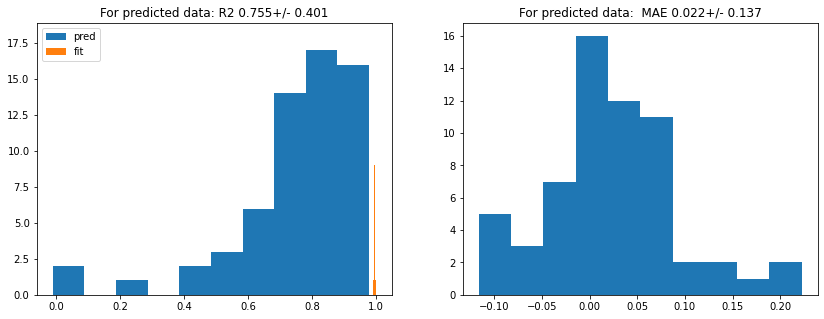

In [92]:
training_details = filteting +"/test"    
df = test_small
test_pred =  ReconstructSVR_all_drugs(df, all_columns, "sigmoid_4_param", 
                                      conc_columns, response_norm, n_coef = 4, 
                                      recompute_predictions = False,
                                      #model_dict=None, scaler_dict=None, 
                                      training_details=training_details, drop_columns=True)
print(test_pred.shape)
#statistics by drug
gr = test_pred.groupby("DRUG_ID")[["sigmoid_4_param_r2","pred_fit_r2", "mae_pred"]].mean()
gr

fig = plt.figure(figsize=(14, 5))
fig.subplots_adjust(hspace=0.4)

ax = fig.add_subplot(121) #fig.add_subplot(ROW,COLUMN,POSITION)
ax.hist(gr["pred_fit_r2"], label= "pred")
ax.hist(gr["sigmoid_4_param_r2"], label= "fit")
ax.legend()

ax.set_title("For predicted data: R2 %0.3f+/- %0.3f" % (gr["pred_fit_r2"].mean(), 2*gr["pred_fit_r2"].std()))

ax = fig.add_subplot(122)
ax.hist(gr["mae_pred"])
ax.set_title("For predicted data:  MAE %0.3f+/- %0.3f" % (gr["mae_pred"].mean(), 2*gr["mae_pred"].std()));


In [ ]:
%%time

filteting = "no_filt"
_FOLDER_3= _FOLDER_2 + filteting + "/"

train = pd.read_csv(_FOLDER_3+ "train.csv")
test = pd.read_csv(_FOLDER_3+ "test.csv")
test2 = pd.read_csv(_FOLDER_3+ "test2.csv")
print(train.shape, test.shape, test2.shape)


model_dict = {}
scaler_dict = {}

for i in range(1,5):
    print("\nComputing model for coefficent ", i)
    
    model, scaler = Train_SVR_all(train, X_columns = all_columns, coefficient=i, 
                              **parameters_model[i])
    model_dict[i] = model
    scaler_dict[i] = scaler

    TestSVRCoef_all_drugs(test, all_columns, model, scaler, coefficient=i, training_details= filteting+ "/test")
    TestSVRCoef_all_drugs(test2, all_columns, model, scaler, coefficient=i, training_details= filteting+ "/test2")
    TestSVRCoef_all_drugs(test_small, all_columns, model, scaler, coefficient=i, training_details= filteting+ "/test_r2>0.9")
    TestSVRCoef_all_drugs(test_small2, all_columns, model, scaler, coefficient=i, training_details=filteting+ "/test_r2>0.99")
    
    joblib.dump(scaler, _FOLDER_2+ "scaler_" + str(i) + ".sav")
    joblib.dump(model, _FOLDER_3+ "SVR_" + str(i) + ".sav")
    

In [ ]:
training_details = filteting +"/test"    
df = test_small
test_pred =  ReconstructSVR_all_drugs(df, all_columns, "sigmoid_4_param", 
                                      conc_columns, response_norm, n_coef = 4, 
                                      recompute_predictions = False,
                                      model_dict=model_dict, scaler_dict=scaler_dict, 
                                      training_details=training_details, drop_columns=True)
print(test_pred.shape)
#statistics by drug
gr = test_pred.groupby("DRUG_ID")[["sigmoid_4_param_r2","pred_fit_r2", "mae_pred"]].mean()
gr

fig = plt.figure(figsize=(14, 5))
fig.subplots_adjust(hspace=0.4)

ax = fig.add_subplot(121) #fig.add_subplot(ROW,COLUMN,POSITION)
ax.hist(gr["pred_fit_r2"], label= "pred")
ax.hist(gr["sigmoid_4_param_r2"], label= "fit")
ax.legend()

ax.set_title("For predicted data: R2 %0.3f+/- %0.3f" % (gr["pred_fit_r2"].mean(), 2*gr["pred_fit_r2"].std()))

ax = fig.add_subplot(122)
ax.hist(gr["mae_pred"])
ax.set_title("For predicted data:  MAE %0.3f+/- %0.3f" % (gr["mae_pred"].mean(), 2*gr["mae_pred"].std()));
